In [1]:
import numpy as np

from Configuration import Configuration
from Oracle import Oracle
#from Model import TBP_AS_model

filename = "../UD_French-GSD/UD_French-GSD/fr_gsd-ud-train.conllu"
#filename = "../UD_French-GSD/UD_French-GSD/test.conllu"

oracle = Oracle(filename)
oracle.search_transitions()

[{'transition': 'shift'},
 {'transition': 'left', 'type': 'det'},
 {'transition': 'shift'},
 {'transition': 'right', 'type': 'amod'},
 {'transition': 'shift'},
 {'transition': 'shift'},
 {'transition': 'left', 'type': 'aux'},
 {'transition': 'left', 'type': 'nsubj'},
 {'transition': 'shift'},
 {'transition': 'shift'},
 {'transition': 'left', 'type': 'advmod'},
 {'transition': 'shift'},
 {'transition': 'shift'},
 {'transition': 'shift'},
 {'transition': 'left', 'type': 'det'},
 {'transition': 'left', 'type': 'case'},
 {'transition': 'right', 'type': 'obl:mod'},
 {'transition': 'shift'},
 {'transition': 'shift'},
 {'transition': 'shift'},
 {'transition': 'shift'},
 {'transition': 'left', 'type': 'obj'},
 {'transition': 'left', 'type': 'nsubj'},
 {'transition': 'left', 'type': 'mark'},
 {'transition': 'shift'},
 {'transition': 'right', 'type': 'advmod'},
 {'transition': 'shift'},
 {'transition': 'shift'},
 {'transition': 'shift'},
 {'transition': 'left', 'type': 'det'},
 {'transition': 'l

In [23]:
from keras.preprocessing.text import one_hot

x = np.array(oracle.features)
y = np.array(oracle.transitions)

y = np.array([k['transition']for k in y])
#shift:0, right:1, left:2
new_y = []
for i in range(len(y)):
    if y[i]=='shift':
        new_y.append([1,0,0])
    elif y[i]=='right':
        new_y.append([0,1,0])
    elif y[i]=='left':
        new_y.append([0,0,1])
        
y = np.array(new_y)
x.shape, y.shape

((692763, 10), (692763, 3))

In [24]:
x[0], y[0]

(array(['ROOT', 'ROOT', 'ROOT', 'nan', 'DET', 'le',
        'Definite=Def|Gender=Fem|Number=Plur|PronType=Art', 'NOUN', 'DET',
        '1'], dtype='<U62'), array([1, 0, 0]))

In [25]:
x_t = x

In [29]:
x=x_t
vocs = [np.array(list(set(x[:,i]))) for i in range(np.shape(x)[1])]
import time
t = time.time()
res = [[np.argwhere(vocs[j]==x[i,j]) for j,feature in enumerate(features)] for i,features in enumerate(x)]
print(time.time()-t)

665.5401225090027


ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [31]:
x_new = res

In [4]:
vocs = [np.array(list(set(x[:,i]))) for i in range(np.shape(x)[1])]
x_new = [[np.argwhere(vocs[j]==x[i,j]) for j,feature in enumerate(features)] for i,features in enumerate(x)]

In [33]:
x_new = np.squeeze(x_new)

In [34]:
np.shape(x_new)

(692763, 10)

In [35]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Flatten, Input, Dropout, BatchNormalization, Input, Concatenate
from keras.optimizers import Adam

def build_model(vocs):
    n_features = len(vocs)
    
    input_features = [Input(shape=(1,)) for _ in range(n_features)]
    features = [Embedding(len(vocs[i]), min(32, len(vocs[i])))(f) for i,f in enumerate(input_features)]
    features = [Flatten()(f) for i,f in enumerate(features)]
    features = Concatenate()(features)
    
    input_shape = np.sum([min(32, len(vocs[i])) for i,f in enumerate(input_features)])
    
    model = Sequential()
    model.add(Dense(input_shape, input_shape=(input_shape,), activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(BatchNormalization())

    output = model(features)

    transition = Dense(3, activation="tanh")(output)

    classifier =  Model(input_features, transition)

    losses = ['categorical_crossentropy']
    classifier.compile(loss=losses,
                optimizer='adam',
                metrics=['accuracy'])

    classifier.summary()
    return classifier

classifier = build_model(vocs=vocs)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (I

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.33, random_state=42)

In [37]:
X_train[:10].T.tolist()

[[16, 1, 17, 17, 16, 17, 17, 13, 16, 16],
 [5170, 4701, 8085, 8085, 14279, 8085, 8085, 12766, 1400, 10558],
 [59, 16, 4, 20, 59, 0, 20, 49, 29, 69],
 [17, 14, 12, 1, 14, 9, 9, 7, 1, 17],
 [6, 1, 15, 15, 10, 2, 15, 1, 10, 1],
 [26252, 10013, 12358, 7445, 9207, 12980, 23905, 9832, 28095, 24161],
 [108, 31, 30, 62, 108, 10, 62, 128, 108, 108],
 [11, 11, 9, 9, 7, 12, 9, 15, 17, 11],
 [7, 7, 5, 17, 7, 7, 9, 17, 7, 7],
 [28, 63, 110, 85, 28, 85, 85, 110, 85, 27]]

In [38]:
import matplotlib.pyplot as plt
def plot_hist(hist):
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.title('Loss')
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='valid')
    plt.yscale('log')
    plt.ylabel('categorical_crossentropy')
    plt.xlabel('epoch')
    plt.grid(which='both')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title('Accuracy')
    plt.plot(hist.history['acc'], label='train')
    plt.plot(hist.history['val_acc'], label='valid')
    plt.yscale('log')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.grid(which='both')
    plt.legend()
    
    plt.show()

In [39]:
hist1 = classifier.fit(X_train.T.tolist(), y_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test.T.tolist(), y_test), shuffle=True)

Train on 464151 samples, validate on 228612 samples
Epoch 1/10
464151/464151 [==============================] - 20s 43us/step - loss: 2.7629 - acc: 0.3602 - val_loss: 2.1831 - val_acc: 0.4193
Epoch 2/10
464151/464151 [==============================] - 11s 23us/step - loss: 1.8620 - acc: 0.4113 - val_loss: 1.3890 - val_acc: 0.4245
Epoch 3/10
464151/464151 [==============================] - 11s 23us/step - loss: 1.6534 - acc: 0.4101 - val_loss: 1.4826 - val_acc: 0.3897
Epoch 4/10
464151/464151 [==============================] - 12s 25us/step - loss: 1.4849 - acc: 0.3946 - val_loss: 1.2389 - val_acc: 0.3794
Epoch 5/10
464151/464151 [==============================] - 12s 25us/step - loss: 1.3817 - acc: 0.3811 - val_loss: 1.1979 - val_acc: 0.3551
Epoch 6/10
464151/464151 [==============================] - 11s 23us/step - loss: 1.3287 - acc: 0.3578 - val_loss: 1.1649 - val_acc: 0.3228
Epoch 7/10
464151/464151 [==============================] - 11s 24us/step - loss: 1.2728 - acc: 0.3345 - val

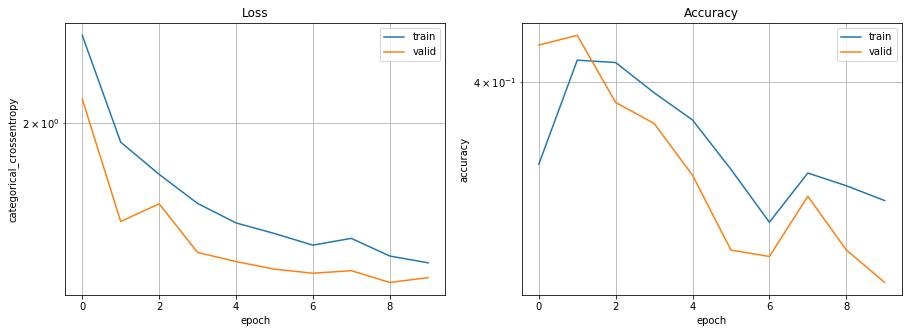

In [40]:
plot_hist(hist1)

In [41]:
hist2 = classifier.fit(X_train.T.tolist(), y_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test.T.tolist(), y_test), shuffle=True)

Train on 464151 samples, validate on 228612 samples
Epoch 1/10
464151/464151 [==============================] - 11s 24us/step - loss: 1.1915 - acc: 0.3445 - val_loss: 1.1021 - val_acc: 0.3410
Epoch 2/10
464151/464151 [==============================] - 11s 24us/step - loss: 1.1610 - acc: 0.3514 - val_loss: 1.0898 - val_acc: 0.3484
Epoch 3/10
464151/464151 [==============================] - 12s 25us/step - loss: 1.1558 - acc: 0.3488 - val_loss: 1.0974 - val_acc: 0.3573
Epoch 4/10
464151/464151 [==============================] - 11s 24us/step - loss: 1.1410 - acc: 0.3729 - val_loss: 1.1163 - val_acc: 0.3836
Epoch 5/10
464151/464151 [==============================] - 11s 24us/step - loss: 1.1463 - acc: 0.3778 - val_loss: 1.1016 - val_acc: 0.3496
Epoch 6/10
464151/464151 [==============================] - 15s 33us/step - loss: 1.1285 - acc: 0.3695 - val_loss: 1.0953 - val_acc: 0.3580
Epoch 7/10
464151/464151 [==============================] - 16s 35us/step - loss: 1.1155 - acc: 0.3620 - val

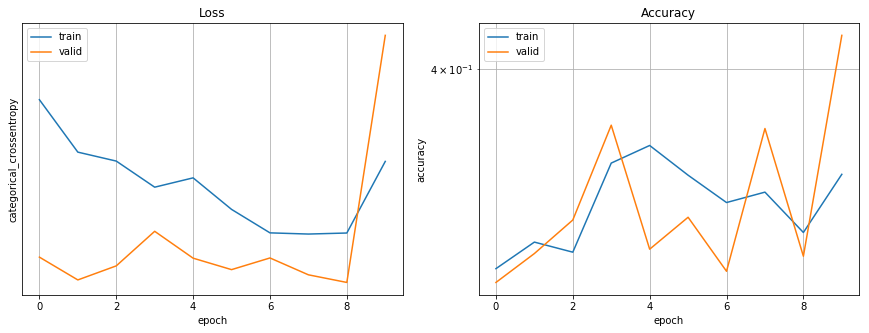

In [42]:
plot_hist(hist2)

In [43]:
hist3 = classifier.fit(X_train.T.tolist(), y_train, batch_size=512, epochs=10, verbose=1, validation_data=(X_test.T.tolist(), y_test), shuffle=True)

Train on 464151 samples, validate on 228612 samples
Epoch 1/10
464151/464151 [==============================] - 21s 45us/step - loss: 1.1382 - acc: 0.3817 - val_loss: 1.0932 - val_acc: 0.3921
Epoch 2/10
464151/464151 [==============================] - 35s 75us/step - loss: 1.1160 - acc: 0.3838 - val_loss: 1.0993 - val_acc: 0.4023
Epoch 3/10
464151/464151 [==============================] - 32s 68us/step - loss: 1.1313 - acc: 0.3892 - val_loss: 1.0851 - val_acc: 0.3469
Epoch 4/10
464151/464151 [==============================] - 29s 62us/step - loss: 1.1224 - acc: 0.3741 - val_loss: 1.1032 - val_acc: 0.4067
Epoch 5/10
464151/464151 [==============================] - 31s 66us/step - loss: 1.1327 - acc: 0.3729 - val_loss: 1.0713 - val_acc: 0.3811
Epoch 6/10
464151/464151 [==============================] - 31s 67us/step - loss: 1.1225 - acc: 0.3781 - val_loss: 1.0990 - val_acc: 0.3875
Epoch 7/10
464151/464151 [==============================] - 32s 68us/step - loss: 1.1160 - acc: 0.3618 - val

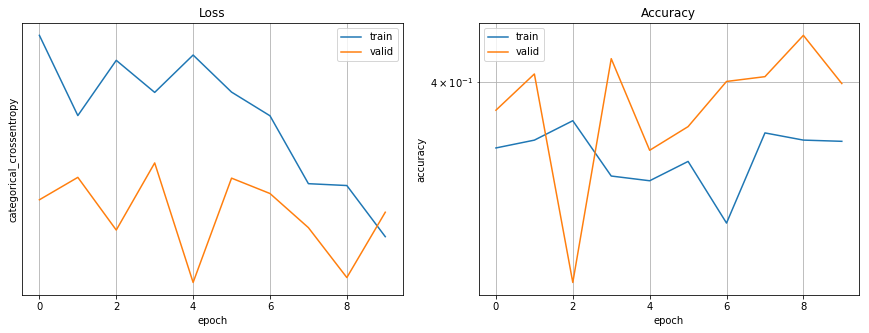

In [44]:
plot_hist(hist3)

In [ ]:
hist4 = classifier.fit(X_train.T.tolist(), y_train, batch_size=512, epochs=10, verbose=1, validation_data=(X_test.T.tolist(), y_test), shuffle=True)

Train on 464151 samples, validate on 228612 samples
Epoch 1/10
464151/464151 [==============================] - 33s 70us/step - loss: 1.0938 - acc: 0.3869 - val_loss: 1.0960 - val_acc: 0.3827
Epoch 2/10
464151/464151 [==============================] - 35s 75us/step - loss: 1.0840 - acc: 0.3694 - val_loss: 1.0654 - val_acc: 0.3736
Epoch 3/10
464151/464151 [==============================] - 31s 67us/step - loss: 1.0964 - acc: 0.3753 - val_loss: 1.0712 - val_acc: 0.3503
Epoch 4/10
464151/464151 [==============================] - 28s 61us/step - loss: 1.0894 - acc: 0.3671 - val_loss: 1.0811 - val_acc: 0.3499
Epoch 5/10
464151/464151 [==============================] - 33s 70us/step - loss: 1.0922 - acc: 0.3616 - val_loss: 1.0754 - val_acc: 0.3800
Epoch 6/10
464151/464151 [==============================] - 27s 59us/step - loss: 1.0983 - acc: 0.3686 - val_loss: 1.0842 - val_acc: 0.3753
Epoch 7/10
464151/464151 [==============================] - 32s 68us/step - loss: 1.1095 - acc: 0.3897 - val

In [ ]:
plot_hist(hist4)